# Code for getting Exoplanets w Unknown orbital parameters from FFIs

# How to use
Search a single target from FFI:
* results = ffi_planet_search('TIC 307210830')

Or just extract light curve:
* lc = extract_lightcurve_from_ffi('TIC 307210830')

Batch search:
* tic_list = [307210830, 141914082, 231670397]
* df, results = batch_ffi_search(tic_list)


Initial imports

In [14]:
import os
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from astropy.timeseries import BoxLeastSquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Extracting Light Curve from FFI
* downloads FFI data from TESS
* cuts out small region around target star
* uses apterature photometry to create light curve

In [37]:
def extract_lightcurve_from_ffi(target, sector=None, cutout_size=15, 
                                 aperture_radius=1, quality_bitmask='default'):
    """
    Extract a light curve from TESS Full Frame Images (FFIs).
    
    target(str/int)
        Target name (e.g., 'TIC 307210830') or TIC ID
    sector(int/None)
        Specific sector to download, or None for all available
    cutout_size(int)
        Size of cutout in pixels (default is currently 15x15)
    aperture_radius(float)
        Radius for aperture photometry (in pixels)
    quality_bitmask(str)
        Quality mask for data filtering
    """
    
    if isinstance(target, int):
        target = f"TIC {target}"
    
    print(f"Extracting FFI light curve for {target}")
    print("This may take awhile")
    
    try:
        # Search for FFI data
        print("  Searching for FFI data...")
        search_result = lk.search_tesscut(target)
        
        if len(search_result) == 0:
            print(f"    No FFI data found for {target}")
            return None
        
        # Filter by sector if we get result
        if sector is not None:
            search_result = search_result[search_result.mission == f'TESS Sector {sector}']
            if len(search_result) == 0:
                print(f"    No data in sector {sector}")
                return None
        
        print(f"    Found FFI data in {len(search_result)} sector(s)")
        
        # Download FFI cutouts
        print(f"  Downloading {cutout_size}x{cutout_size} pixel cutouts...")
        tpf_collection = search_result.download_all(cutout_size=cutout_size)
        
        if tpf_collection is None or len(tpf_collection) == 0:
            print("    Download failed")
            return None
        
        # Extract light curves from each sector
        lc_list = []
        
        for tpf in tpf_collection:
            try:
                print(f"  Processing Sector {tpf.sector}...")
                
                # Create aperture mask
                # Threshold mask (recommended for FFI): 3
                aperture_mask = tpf.create_threshold_mask(threshold=3, reference_pixel='center')
                
                # If threshold mask fails, try lower threshold: 1
                if aperture_mask.sum() == 0:
                    print("    Threshold mask empty, trying lower threshold...")
                    aperture_mask = tpf.create_threshold_mask(threshold=1, reference_pixel='center')
                
                if aperture_mask.sum() == 0:
                    print("    Using circular aperture...")
                    # Create circular aperture
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= aperture_radius:
                                aperture_mask[i, j] = True
                
                print(f"    Aperture size: {aperture_mask.sum()} pixels")
                
                # Perform aperture photometry
                lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
                
                # Filtering for quality
                lc = lc[lc.quality == 0]  # Want only best quality
                
                # Remove NaNs
                lc = lc.remove_nans()
                
                if len(lc) < 100:
                    print(f"      Too few data points after quality filtering ({len(lc)})")
                    continue
                
                print(f"      Extracted {len(lc)} data points")
                lc_list.append(lc)
                
            except Exception as e:
                print(f"      Error in Sector {tpf.sector}: {e}")
                continue
        
        if len(lc_list) == 0:
            print("    No valid light curves extracted")
            return None
        
        # Stitch light curves together
        print(f"  Stitching {len(lc_list)} sector(s) together...")
        combined_lc = lc_list[0]
        for lc in lc_list[1:]:
            combined_lc = combined_lc.append(lc)
        
        # Normalize
        combined_lc = combined_lc.normalize()
        
        print(f"    Final light curve: {len(combined_lc)} points, {combined_lc.time[-1].value - combined_lc.time[0].value:.1f} day baseline")
        
        return combined_lc
        
    except Exception as e:
        print(f"    Extraction failed: {e}")
        return None

# Search for planet from FFI Light Curve
* takes extracted FFI light curve and runs Boxed Least Squared to find periodic transit signals
* create plot
* if found, returns planet parameters

In [38]:
def search_for_planets_in_ffi(lightcurve, period_min=0.5, period_max=30, 
                               detrend=True, plot=True):
    """
    Search for exoplanet transits in an FFI-derived light curve using Boxed Least Squares (BLS)
    
    period_min, period_max(float)
        in days
    detrend(bool)
        whether to flatten/detrend  light curve
    plot(bool)
        Whether to create diagnostic plots, t/f
    """
    
    print("\n" + "="*20)
    print("Looking for Transits")
    print("="*20)
    
    lc = lightcurve.copy()
    
    # Detrending and cleaning
    if detrend:
        print("Detrending light curve...")
        
        # Remove outliers before flattening
        lc = lc.remove_outliers(sigma=5)
        
        # Flatten to remove stellar variability
        # Window length depends on minimum period (making it 2.5 times as long here, can change)
        # *also* convert to number of cadences (not days)
        median_cadence = np.median(np.diff(lc.time.value))  # days
        window_length_days = max(1.0, period_min * 2.5)  # days
        window_length_cadences = int(window_length_days / median_cadence) # convert to number of candences
        
        # Must be odd number
        if window_length_cadences % 2 == 0:
            window_length_cadences += 1
        
        # Ensure reasonable range
        window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
        
        print(f"  Flattening with window = {window_length_cadences} cadences ({window_length_cadences * median_cadence:.1f} days)")
        lc = lc.flatten(window_length=window_length_cadences)
        
        # Remove outliers again after flattening
        lc = lc.remove_outliers(sigma=4)
        
        # Sigma clipping
        flux_median = np.median(lc.flux.value)
        flux_std = np.std(lc.flux.value)
        mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
        lc = lc[mask_good]
        
        print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    # Prepare data for BLS
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Run BLS --> this is where detect planet
    print(f"Running BLS (searching periods {period_min:.1f} - {period_max:.1f} days)...")
    
    model = BoxLeastSquares(time, flux, flux_err)
    
    # Create period grid (denser for better accuracy)
    periods = np.linspace(period_min, period_max, 10000)
    
    # Duration grid (0.5 hours to 8 hours)
    durations = np.linspace(0.02, 0.33, 15)  # in days
    
    # Compute periodogram
    bls_result = model.power(periods, durations)
    
    # Extract best result
    best_idx = np.argmax(bls_result.power)
    
    results = {
        'period': bls_result.period[best_idx],
        'duration': bls_result.duration[best_idx],
        't0': bls_result.transit_time[best_idx],
        'depth': bls_result.depth[best_idx],
        'depth_ppm': bls_result.depth[best_idx] * 1e6,
        'power': bls_result.power[best_idx],
        'snr': bls_result.depth[best_idx] / bls_result.depth_err[best_idx],
        'n_transits': int((time[-1] - time[0]) / bls_result.period[best_idx]),
        'lightcurve': lc,
        'bls_result': bls_result
    }
    
    print("\nBLS RESULTS:")
    print(f"  Period: {results['period']:.4f} days")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Transit depth: {results['depth_ppm']:.1f} ppm ({results['depth']*100:.3f}%)")
    print(f"  BLS Power: {results['power']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Expected transits: {results['n_transits']}")
    
    # Plotting
    if plot:
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Full light curve
        ax1 = plt.subplot(3, 2, 1)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('(Cleaned) FFI Light Curve', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time [BTJD]')
        ax1.set_ylabel('Normalized Flux')
        
        # 2. BLS Periodogram
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(bls_result.period, bls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, 
                    label=f"Best Period = {results['period']:.3f} d")
        ax2.set_xlabel('Period (days)')
        ax2.set_ylabel('BLS Power')
        ax2.set_title('BLS Periodogram', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Folded light curve (all points)
        ax3 = plt.subplot(3, 2, 3)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded Light Curve (P={results['period']:.4f} d)", 
                     fontsize=14, fontweight='bold')
        ax3.set_xlabel('Phase')
        ax3.set_ylabel('Normalized Flux')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        # 4. Binned folded light curve
        ax4 = plt.subplot(3, 2, 4)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red')
        ax4.set_title(f"Binned Transit (Depth={results['depth_ppm']:.1f} ppm)", 
                     fontsize=14, fontweight='bold')
        ax4.set_xlabel('Phase')
        ax4.set_ylabel('Normalized Flux')
        ax4.axvline(0, color='red', ls='--', alpha=0.5)
        ax4.grid(alpha=0.3)
        
        # 5. Individual transits
        ax5 = plt.subplot(3, 2, 5)
        transit_times = results['t0'] + results['period'] * np.arange(-10, 100)
        transit_times = transit_times[(transit_times >= time[0]) & (transit_times <= time[-1])]
        
        ax5.plot(time, flux, 'k.', ms=1, alpha=0.5)
        for tt in transit_times:
            ax5.axvline(tt, color='red', alpha=0.3, lw=1)
        ax5.set_xlabel('Time [BTJD]')
        ax5.set_ylabel('Normalized Flux')
        ax5.set_title(f'Predicted Transit Times (n={len(transit_times)})', 
                     fontsize=14, fontweight='bold')
        
        # 6. Zoomed transit
        ax6 = plt.subplot(3, 2, 6)
        if len(transit_times) > 0:
            # Zoom to first transit
            first_transit = transit_times[0]
            transit_window = results['duration'] * 3
            mask_zoom = (time > first_transit - transit_window) & (time < first_transit + transit_window)
            
            if mask_zoom.sum() > 0:
                ax6.plot(time[mask_zoom], flux[mask_zoom], 'ko', ms=3)
                ax6.axvline(first_transit, color='red', ls='--', alpha=0.5)
                ax6.set_xlabel('Time [BTJD]')
                ax6.set_ylabel('Normalized Flux')
                ax6.set_title('First Transit (Zoomed)', fontsize=14, fontweight='bold')
                ax6.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

# Check detected light curves from FFI data
* checks if planet candidates are real

In [39]:
def vet_ffi_detection(results):
    """
    Check a planet candidate from FFI data.
    FFI has different characteristics than 2-min cadence data.
    """
    
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    power = results['power']
    snr = results.get('snr', 0)
    n_transits = results.get('n_transits', 0)

    # Assume good to start
    verdict = "GOOD"
    reasons = []
    
    # 1. Check period
    if period < 0.5:
        verdict = "BAD"
        reasons.append(f"Period too short ({period:.2f}d) - likely noise or systematics")
    
    # Check for FFI cadence artifacts (30 min = 0.0208 days)
    ffi_cadence = 0.0208
    for mult in range(1, 10):
        if abs(period - mult * ffi_cadence) < 0.002:
            verdict = "BAD"
            reasons.append(f"Period matches FFI cadence artifact ({mult}×30min)")
            break
    
    # Check for sector length artifacts
    sector_length = 27.4
    for mult in [1, 2, 3]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches sector artifact ({mult}×27.4d)")
            break
    
    # 2. Check depth
    if depth_ppm > 50000:  # >5%
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm) - likely eclipsing binary")
    
    if depth_ppm < 50:  # <50 ppm
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Very shallow ({depth_ppm:.0f} ppm) - hard to detect in FFI")
    
    # 3. Duration checks
    if duration_hrs < 0.5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Short duration ({duration_hrs:.1f}h) - near FFI time resolution")
    
    if duration_hrs > 12:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Long duration ({duration_hrs:.1f}h) - unusual")
    
    # 4. Check SNR and power 
    if power < 50:
        verdict = "BAD"
        reasons.append(f"Low BLS power ({power:.0f}) - weak signal")
    
    if snr < 5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Low SNR ({snr:.1f}) - needs confirmation")
    
    # 5. Count transits
    if n_transits < 3:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Only {n_transits} transits - needs more data")
    
    # If no issues found --> good
    if len(reasons) == 0:
        reasons.append(f"Passes all checks: P={period:.2f}d, depth={depth_ppm:.0f}ppm, {n_transits} transits")
    
    return verdict, reasons

# Prints vetting results

In [40]:
def print_ffi_vet_result(target, results):
    """Print vetting results for FFI detection"""
    verdict, reasons = vet_ffi_detection(results)
    
    print("\n" + "="*70)
    print("VETTING RESULTS")
    print("="*70)
    
    if verdict == "GOOD":
        print(f"  {target}: GOOD CANDIDATE")
    elif verdict == "SUSPICIOUS":
        print(f"  {target}: SUSPICIOUS - NEEDS REVIEW")
    else:
        print(f"  {target}: LIKELY FALSE POSITIVE")
    
    print("\nReasons:")
    for reason in reasons:
        print(f"  • {reason}")
    print("="*20)

# Complete Planet Search
Using functions from above ^
* also checks detection

In [41]:
def ffi_planet_search(target, period_min=0.5, period_max=30, 
                      cutout_size=15, plot=True):
    """
    Extract FFI light curve → Search for planets → Vet
    
    Parameters:
    -----------
    target(str/int)
        (TIC ID or name)
    period_min, period_max(float)
        in days
    cutout_size(int)
        FFI cutout size in pixels
    plot(bool)
        Create diagnostic plots
    """
    
    print("\n" + "="*20)
    print(f"FFI EXOPLANET SEARCH: {target}")
    print("="*20)
    
    # Step 1: Extract light curve from FFI
    lc = extract_lightcurve_from_ffi(target, cutout_size=cutout_size)
    
    if lc is None:
        print("\n  Failed to extract light curve")
        return None
    
    # Step 2: Search for planets
    results = search_for_planets_in_ffi(lc, period_min=period_min, 
                                         period_max=period_max, plot=plot)
    
    if results is None:
        print("\n  Planet search failed")
        return None
    
    # Step 3: Vet the detection
    print_ffi_vet_result(target, results)
    
    return results

# Search multiple stars at once from FFI data

In [42]:
def batch_ffi_search(tic_ids, period_min=0.5, period_max=30, 
                     save_results=True):
    
    all_results = []
    
    print("\n" + "="*20)
    print(f"BATCH FFI SEARCH: {len(tic_ids)} TARGETS")
    print("="*20)
    
    for i, tic_id in enumerate(tic_ids, 1):
        print(f"\n[{i}/{len(tic_ids)}] Processing TIC {tic_id}...")
        
        try:
            result = ffi_planet_search(tic_id, period_min=period_min, 
                                       period_max=period_max, plot=False)
            
            if result is not None:
                verdict, _ = vet_ffi_detection(result)
                result['verdict'] = verdict
                result['tic_id'] = tic_id
                all_results.append(result)
                
        except Exception as e:
            print(f"✗ Error processing TIC {tic_id}: {e}")
    
    # Summary
    if len(all_results) > 0:
        # Remove non-serializable objects for DataFrame
        df_results = []
        for r in all_results:
            df_results.append({
                'tic_id': r['tic_id'],
                'period': r['period'],
                'depth_ppm': r['depth_ppm'],
                'duration_hrs': r['duration'] * 24,
                'power': r['power'],
                'snr': r['snr'],
                'n_transits': r['n_transits'],
                'verdict': r['verdict']
            })
        
        df = pd.DataFrame(df_results)
        df = df.sort_values('power', ascending=False)
        
        print("\n" + "="*20)
        print("Finished Batch Search")
        print("="*20)
        print(f"\nSuccessfully analyzed: {len(df)} targets\n")
        print(df.to_string(index=False))
        
        n_good = (df['verdict'] == 'GOOD').sum()
        n_susp = (df['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df['verdict'] == 'BAD').sum()
        
        print(f"\nSUMMARY:")
        print(f"     Good: {n_good}")
        print(f"     Suspicious: {n_susp}")
        print(f"     False positives: {n_bad}")
        
        if save_results:
            df.to_csv('ffi_planet_search_results.csv', index=False)
            print(f"\nResults saved to ffi_planet_search_results.csv")
        
        return df, all_results  # Returns both DataFrame and full results
    
    return None, None

# Example Code (for testing)
* this is a known TIC with known orbital paramters
* (want to clarify) this is just for testing!

In [31]:
# search specific TIC
# testing a known TICs to see if FFI extraction works
tic_list = [307210830, 141914082, 231670397]
df_results, full_results = batch_ffi_search(tic_list)


BATCH FFI SEARCH: 3 TARGETS

[1/3] Processing TIC 307210830...

FFI EXOPLANET SEARCH: 307210830
Extracting FFI light curve for TIC 307210830
  Searching for FFI data...
    Found FFI data in 28 sector(s)
  Processing Sector 5...
    Aperture size: 22 pixels
      Extracted 1176 data points
  Processing Sector 1...
    Threshold mask empty, trying lower threshold...
    Aperture size: 38 pixels
      Extracted 1267 data points
  Processing Sector 2...
    Aperture size: 23 pixels
      Extracted 1196 data points
  Processing Sector 10...
    Aperture size: 19 pixels
      Extracted 1150 data points
  Processing Sector 11...
    Aperture size: 21 pixels
      Extracted 1180 data points
  Processing Sector 12...
    Aperture size: 14 pixels
      Extracted 1234 data points
  Processing Sector 8...
    Aperture size: 21 pixels
      Extracted 951 data points
  Processing Sector 9...
    Aperture size: 18 pixels
      Extracted 1084 data points
  Processing Sector 32...
    Aperture size: 


FFI EXOPLANET SEARCH: TIC 307210830
Extracting FFI light curve for TIC 307210830
  Searching for FFI data...
    Found FFI data in 28 sector(s)
  Processing Sector 5...
    Aperture size: 22 pixels
      Extracted 1176 data points
  Processing Sector 1...
    Threshold mask empty, trying lower threshold...
    Aperture size: 38 pixels
      Extracted 1267 data points
  Processing Sector 2...
    Aperture size: 23 pixels
      Extracted 1196 data points
  Processing Sector 10...
    Aperture size: 19 pixels
      Extracted 1150 data points
  Processing Sector 11...
    Aperture size: 21 pixels
      Extracted 1180 data points
  Processing Sector 12...
    Aperture size: 14 pixels
      Extracted 1234 data points
  Processing Sector 8...
    Aperture size: 21 pixels
      Extracted 951 data points
  Processing Sector 9...
    Aperture size: 18 pixels
      Extracted 1084 data points
  Processing Sector 32...
    Aperture size: 20 pixels
      Extracted 3589 data points
  Processing Sect

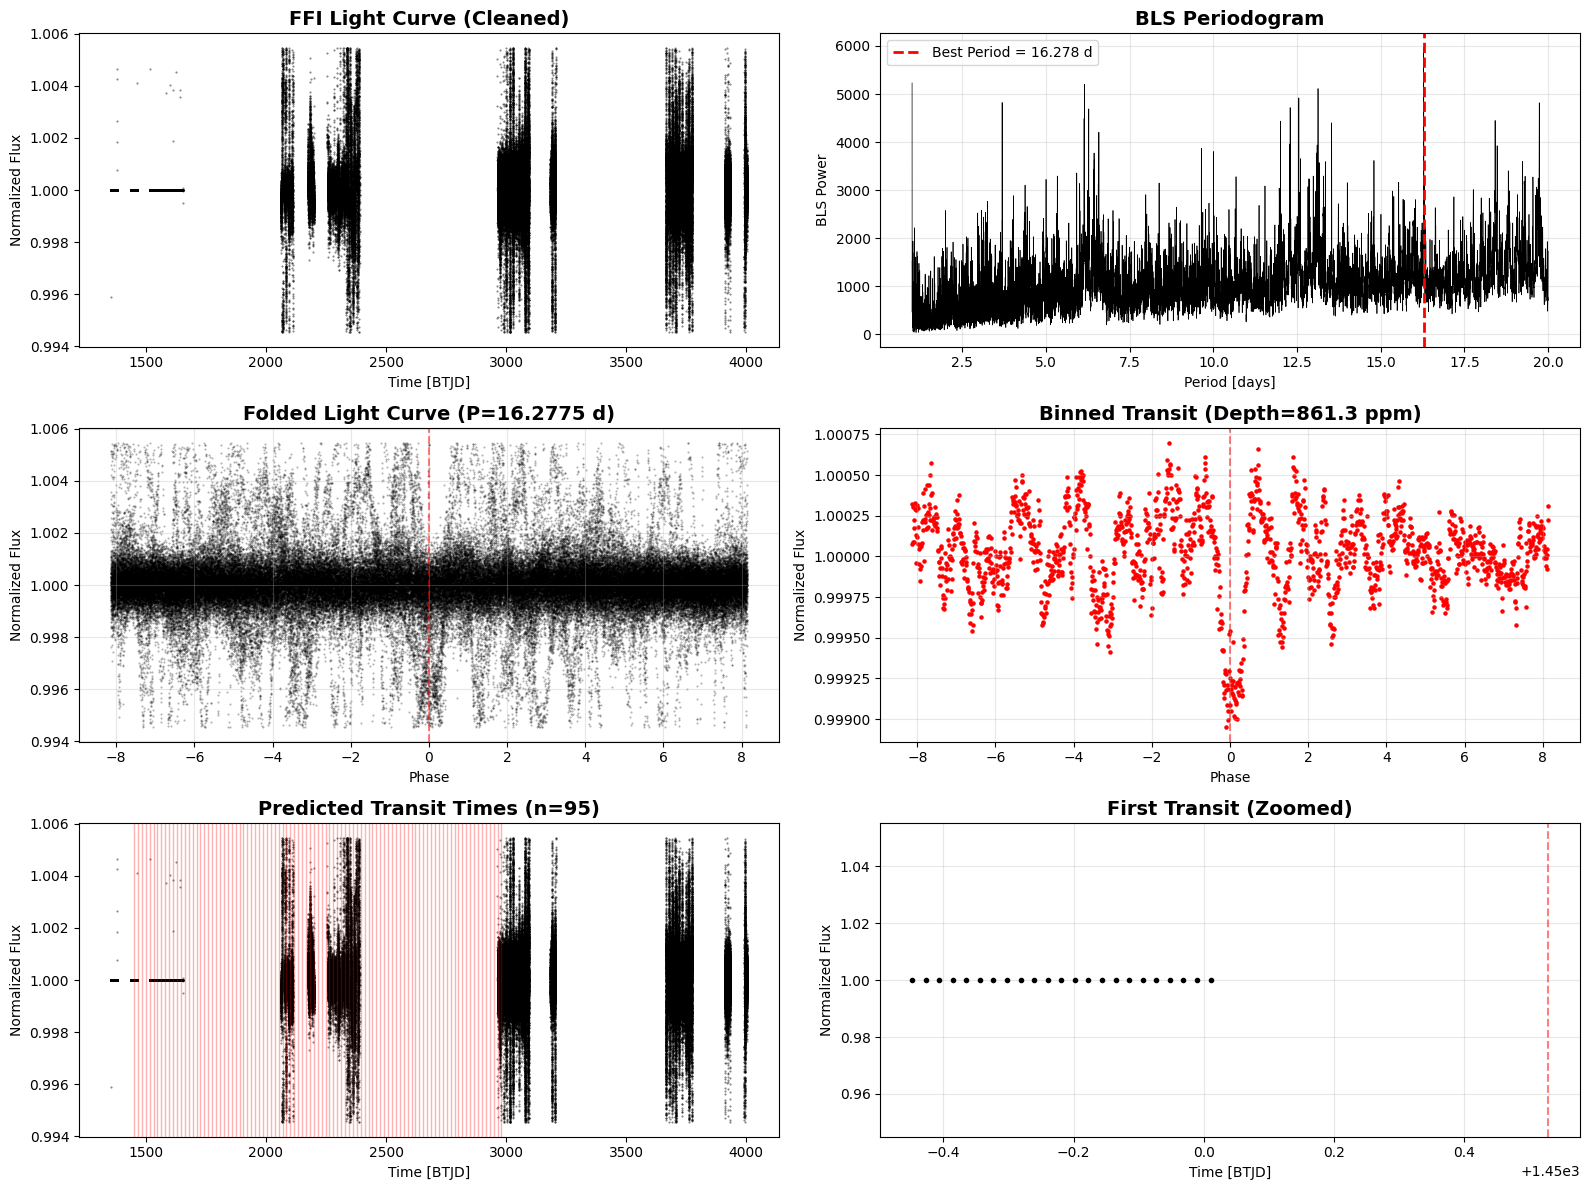


VETTING RESULTS
  TIC 307210830: GOOD CANDIDATE

Reasons:
  • Passes all checks: P=16.28d, depth=861ppm, 157 transits


In [32]:
# test on 1 target:
# Just test one target
results = ffi_planet_search('TIC 307210830', period_min=1, period_max=20, plot=True)

# Finding Unknown Exoplanets
* pretty sure can delete, just keeping for now just in case

In [ ]:
# Step 1: Find stars with unknown planets
df_unknown = search_unknown_planet_candidates(
    min_tmag=8,      # Bright enough for good data
    max_tmag=12,     # Not too faint
    min_sectors=5,   # Need multiple sectors for long periods
    num_targets=20   # How many to find
)

# Step 2: Search them with FFI
tic_list = df_unknown['tic_id'].head(10).tolist()
df_results, full_results = batch_ffi_search(tic_list, period_min=1, period_max=30)

# Step 3: Check which are "GOOD" candidates
good_candidates = df_results[df_results['verdict'] == 'GOOD']
print(good_candidates)

# Searching Exoplanets with known period (via BLS) but unknown radius)
* uses BLS to analyze light curve
* gives better period, transit depth to derive radius
* (later) can use batman to fit transit model to get mass, eccentricity, etc

In [44]:
def search_tois_with_missing_params():
    """
    Find TOIs with missing orbital parameters
    """
    print("=" * 20)
    print("SEARCHING FOR TOIs WITH MISSING ORBITAL PARAMETERS")
    print("=" * 20)
    
    try:
        # Check TOI table
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        # Filter for TOIs with MISSING or UNCERTAIN parameters
        missing_params = df[
            # Has period (transit detected)
            (df['pl_orbper'].notna()) &
            (
                # BUT missing radius
                (df['pl_rade'].isna()) |
                # OR radius uncertain (>20% error)
                (
                    (df['pl_radeerr1'].notna()) & 
                    (df['pl_rade'].notna()) & 
                    ((df['pl_radeerr1'] / df['pl_rade']) > 0.2)
                ) |
                # OR period uncertain (>5% error)
                (
                    (df['pl_orbpererr1'].notna()) & 
                    ((df['pl_orbpererr1'] / df['pl_orbper']) > 0.05)
                )
            )
        ]
        
        # Sort by brightness
        missing_params = missing_params.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_params)} TOIs with incomplete/uncertain parameters")
        
        # Count different categories
        n_missing_radius = missing_params['pl_rade'].isna().sum()
        
        n_uncertain_radius = 0
        if 'pl_radeerr1' in missing_params.columns:
            uncertain_mask = (
                (missing_params['pl_radeerr1'].notna()) & 
                (missing_params['pl_rade'].notna()) & 
                ((missing_params['pl_radeerr1'] / missing_params['pl_rade']) > 0.2)
            )
            n_uncertain_radius = uncertain_mask.sum()
        
        n_uncertain_period = 0
        if 'pl_orbpererr1' in missing_params.columns:
            uncertain_per_mask = (
                (missing_params['pl_orbpererr1'].notna()) & 
                ((missing_params['pl_orbpererr1'] / missing_params['pl_orbper']) > 0.05)
            )
            n_uncertain_period = uncertain_per_mask.sum()
        
        print("\nCategories:")
        print(f"  - Missing radius: {n_missing_radius}")
        print(f"  - Uncertain radius (>20% error): {n_uncertain_radius}")
        print(f"  - Uncertain period (>5% error): {n_uncertain_period}")

        # gets top 20 candidates, can change later
        print("\nTop 20 candidates (brightest stars):")
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        print(missing_params[display_cols].head(20).to_string(index=False))
        
        return missing_params
        
    except Exception as e:
        print(f"Error: {e}")
        return None

* checking code for TOIs w missing paramters

In [45]:
# Find TOIs w missing orbital parameters
df_incomplete = search_tois_with_missing_params()

# Then analyze TOIs
if df_incomplete is not None and len(df_incomplete) > 0:
    print("\n" + "="*20)
    print("Analyzing TOIs with BLS code...")
    print("="*20)
    
    # Pick top 5 brightest
    tic_list = df_incomplete['tic_id'].head(5).tolist()
    
    print(f"\nSelected TICs: {tic_list}")
    print(f"\nAnalyzing {len(tic_list)} TOIs with missing parameters...")
    
    # Run FFI analysis
    df_results, full_results = batch_ffi_search(tic_list, period_min=0.5, period_max=50)
    
    if df_results is not None:
        print("\n" + "="*20)
        print("COMPARING RESULTS TO CATALOG:")
        print("="*20)
        
        # Compare your measurements to catalog
        for tic in tic_list:
            if tic in df_results['tic_id'].values:
                your_result = df_results[df_results['tic_id'] == tic].iloc[0]
                catalog = df_incomplete[df_incomplete['tic_id'] == tic].iloc[0]
                
                print(f"\nTIC {tic} (TOI {catalog['toi']}):")
                print(f"  Catalog Period: {catalog['pl_orbper']:.4f} days")
                print(f"  Calculated Period:    {your_result['period']:.4f} days")
                print(f"  Compare to Catalog Radius: {catalog['pl_rade'] if pd.notna(catalog['pl_rade']) else 'MISSING'}")
                print(f"  Calculated Depth:     {your_result['depth_ppm']:.1f} ppm")

SEARCHING FOR TOIs WITH MISSING ORBITAL PARAMETERS

Found 1793 TOIs with incomplete/uncertain parameters

Categories:
  - Missing radius: 507
  - Uncertain radius (>20% error): 1286
  - Uncertain period (>5% error): 0

Top 20 candidates (brightest stars):
    toi    tic_id  pl_orbper   pl_rade  st_tmag
1469.01 283722336   3.092939  1.281532   4.6278
2011.01 136916387  11.577836  1.542213   5.0494
1025.01 297967252   9.683792       NaN   5.5324
1689.01 198384408   9.123810  2.047184   6.3196
1665.01 354006740   1.764060 12.376200   6.4018
 554.02 407966340   3.044044  1.333743   6.4386
6458.01   2507547   9.783193  2.536037   6.4843
4307.02 141186075   4.654580  0.553104   6.6418
6276.01 397362481   6.203161  1.021460   6.7213
6276.03 397362481   7.870866  1.031487   6.7213
6276.02 397362481   4.466068  0.979458   6.7213
 589.01 412961700   2.518385 21.135441   6.7250
 480.01 317548889   6.865958  2.814491   6.7799
1029.01 374908020  36.222140       NaN   6.8410
6074.01  99896567  12.13